## Create an animation
This example uses callbacks to create an animation displayed in the matplotlib figure.

In order to efficiently use CPU and GPU, PlotOptiX runs two parallel threads, each with its own callbacks.
1. Raytracing thread, with callbacks:
   - `on_launch_finished` executed after each `min_accumulation_step` frames are raytraced,
   - `on_rt_accum_done` executed after `max_accumulation_frames` are raytraced,
   - `_scene_rt_starting_callback` is available here (but only for derived GUI classes).
2. Scene compute and update of GPU data callbacks:
   - `on_scene_compute` executed at the start of the raytracing, allowing for CPU computations in parallel to the raytracing,
   - `on_rt_completed` executed after the raytracing is completed, allowing for synchronized update of data without collisions with the image computations on GPU.
   User can suspend/resume execution of these two callbacks at any time in the program.
   
One more callback, `on_initialization`, completes the picture. It is executed once, just before the raytracing thread is started: during construction, if `start_now=True` is set, or otherwise, when `start()` method is called.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt # will show PlotOptiX output inline

import math
import numpy as np
from plotoptix import NpOptiX

In [2]:
class params():
    n = 10
    a = 5
    s = a / n
    xyz = np.mgrid[0:a:s, 0:a:s, 0:a:s].reshape(3,-1).T
    m = xyz.shape[0]
    u = np.zeros((m,3)); u[:,0] = s
    v = np.zeros((m,3)); v[:,1] = s
    w = np.zeros((m,3)); w[:,2] = s
    t = 0

In [3]:
def init(rt: NpOptiX) -> None: # configure data and scene at initialization
    rt.set_data("plot", pos=params.xyz, u=params.u, v=params.v, w=params.w, geom="Parallelepipeds")
    rt.set_param(min_accumulation_step=4, max_accumulation_frames=100)
    rt.setup_camera("cam1", eye=[10, 10, 10], fov=40)
    rt.setup_light("light1", color=10*np.array([0.99, 0.95, 0.91]), radius=4) # default position fits current camera
    rt.set_ambient([0.1, 0.2, 0.3]) # bluish ambient light
    rt.set_background(0)            # black background
    rt.add_postproc("Denoiser")     # denoise each frame

In [4]:
def compute(rt: NpOptiX, delta: int) -> None: # compute scene updates in parallel to the raytracing
    params.t += 0.02 * delta
    cost = math.cos(params.t)
    sint = math.sin(params.t)
    pia = math.pi / params.a
    for i in range(params.m):
        params.u[i] = params.s * 0.5*(1 + math.sin(pia * params.xyz[i,0] + 1.7 * params.t)) * np.array([cost, sint, 0])
        params.v[i] = params.s * 0.5*(1 + math.sin(pia * params.xyz[i,1] + 1.3 * params.t)) * np.array([-sint, cost, 0])
        params.w[i] = 0.5*(1 + math.sin(2 * pia * params.xyz[i,2] + params.t)) * np.array([0, 0, params.s])

In [5]:
def update_data(rt: NpOptiX) -> None:         # this is the place to update data (raytracing is finished here)
    rt.update_data("plot", u=params.u, v=params.v, w=params.w)

In [6]:
def update_image(rt: NpOptiX) -> None:        # update your image here
    imgplot.set_data(rt._img_rgba) # safe to read the image directly, it is locked during the callback
    plt.draw()

<IPython.core.display.Javascript object>


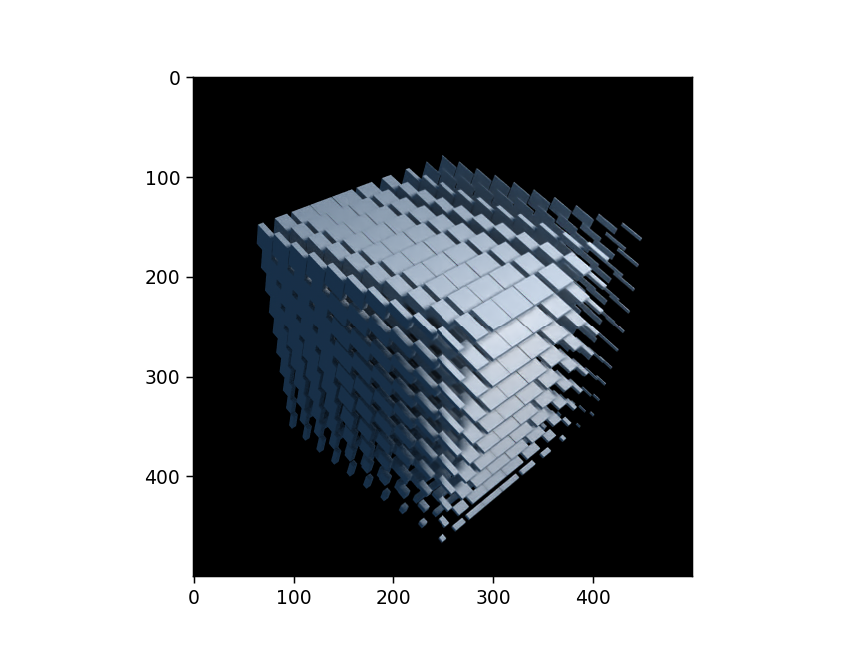

In [7]:
width = height = 500 # square 500x500 pixels
imgplot = plt.imshow(np.zeros((height, width, 4), dtype=np.uint8))

In [8]:
optix = NpOptiX(
    on_initialization=init,
    on_scene_compute=compute,
    on_rt_completed=update_data,
    on_launch_finished=update_image,
    width=width, height=height,
    start_now=True)

The `on_scene_compute` - `on_rt_completed` callbacks can be paused/resumed. Raytracing is still running, until the `max_accumulation_frames` is reached. You can run the two following cells multiple times and see how the image is smoothed out during pause.

In [9]:
optix.pause_compute()

In [10]:
optix.resume_compute()

Finally, `close()` method stops the raytracing which cannot be restarted from that point.

In [11]:
optix.close()